In [1]:
from load_rankings import load_imp
from disagreement_stats import feature_agreement, rank_agreement, rank_correlation, weak_rank_agreement
import itertools
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
def compute_matrices(hazard):

    data, methods, name = load_imp(hazard)
    name_ = name.replace(' ', '')
    n_rankings = len(methods)
    
    feature_agree = np.zeros((n_rankings, n_rankings))
    rank_agree = np.zeros((n_rankings, n_rankings))
    corr = np.zeros((n_rankings, n_rankings))
    
    for i, j in itertools.product(range(n_rankings), range(n_rankings)):
        m1,m2 = methods[i], methods[j]
        
        try:
            r1 = data[i][f'{m1}_rankings__{name}'].values[:10].tolist()
        except:
            r1 = data[i][f'{m1}_rankings__{name_}'].values[:10].tolist()
            
        try:
            r2 = data[j][f'{m2}_rankings__{name}'].values[:10].tolist()
        except:
            r2 = data[j][f'{m2}_rankings__{name_}'].values[:10].tolist()
    
        feature_agree[i,j] = feature_agreement(r1, r2)
        rank_agree[i,j] = weak_rank_agreement(r1, r2)
    
    return feature_agree, rank_agree

In [3]:
results = {}

hazards = ['tornado', 'severe_hail', 'severe_wind', 'road_surface']

fa = []
ra = [] 

for hazard in hazards:
    feature_agree, rank_agree = compute_matrices(hazard)
    
    results[hazard] = {
        'feature_agree' : feature_agree,
        'rank_agree' : rank_agree,
    }
    
    fa.append(feature_agree)
    ra.append(rank_agree)
    
#avg_fa = np.mean(fa, axis=0)
#avg_ra = np.mean(ra, axis=0)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [7]:
def set_row_labels(labels, axes, pos=0, pad=1.15, rotation=90, **kwargs):
        """
        Give a label to each row in a series of subplots
        """
        colors = kwargs.get("colors", ["xkcd:darkish blue"] * len(labels))
        fontsize = kwargs.get("fontsize", 10)

        if np.ndim(axes) == 2:
            iterator = axes[:, pos]
        else:
            iterator = [axes[pos]]

        for ax, row, color in zip(iterator, labels, colors):
            ax.yaxis.set_label_position("right")
            ax.annotate(
                row,
                xy=(1, 1),
                xytext=(pad, 0.5),
                xycoords=ax.transAxes,
                rotation=rotation,
                size=fontsize,
                ha="center",
                va="center",
                color=color,
                alpha=0.65,
            )


def add_alphabet_label(n_panels, axes, pos=(0.9, 0.09), alphabet_fontsize=10, **kwargs):
        """
        A alphabet character to each subpanel.
        """
        alphabet_list = [chr(x) for x in range(ord("a"), ord("z") + 1)] + [
            f"{chr(x)}{chr(x)}" for x in range(ord("a"), ord("z") + 1)
        ]

        ax_iterator = axes.flat

        for i, ax in enumerate(ax_iterator):
            ax.text(
                pos[0],
                pos[1],
                f"({alphabet_list[i]})",
                fontsize=alphabet_fontsize,
                alpha=0.8,
                ha="center",
                va="center",
                transform=ax.transAxes,
            )

def plot_heatmap(ax, data, labels):
    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask)] = True  
    ax = sns.heatmap(data, vmin=0, vmax=1, cmap='Reds', 
                annot=True, annot_kws={'fontsize': 8}, 
                xticklabels=labels, yticklabels=labels,
                ax=ax, mask=mask, cbar=False, square=True,
               )
    
    if len(labels) == 9:
        ax.axvline(x=5, ymax=0.45, ls='dashed', color='white', alpha=1.0, lw=2.25)
        ax.axhline(y=5, xmax=0.5, ls='dashed', color='white', alpha=1.0, lw=2.25)
    else:
        ax.axvline(x=5, ymax=0.5, ls='dashed', color='white', alpha=1.0, lw=2.25)
        ax.axhline(y=5, xmax=0.47, ls='dashed', color='white', alpha=1.0, lw=2.25)
        
    
    avg = np.mean(data[mask==0])
    text = f'Avg. Agrmnt : {avg:.2f}'
    ax.annotate(text, (1.0, 0.84), xycoords='axes fraction', fontsize=7, ha='right')

    avg = np.mean(data[5:, :5])
    text = f'Avg. Agrmnt b/t FI & FR: {avg:.2f}'
    ax.annotate(text, (1.0, 0.79), xycoords='axes fraction', fontsize=7, ha='right')
    
    ax.set_yticklabels(labels, rotation = 'horizontal')
    
    return ax
    
def heatmap_multi(results, hazards):
    
    nrows = len(results[hazards[0]].keys())
    fig, axes = plt.subplots(dpi=300, nrows=2, ncols=4, figsize=(14,6))
    
    modes = ['feature_agree']*len(hazards) + ['rank_agree']*len(hazards)
    hazards_ = hazards + hazards
    
    for ax, hazard, mode in zip(axes.flat, hazards_, modes):
        if hazard != 'road_surface':
            labels = ['BSP', 'BMP', 'FSP', 'FMP', 'SAGE', 'COEF', 'SHAP', 'ALE', 'LIME']
        else:
            labels = ['BSP', 'BMP', 'FSP', 'FMP', 'SAGE', 'GIN', 'SHAP', 'ALE', 'LIME', 'TI']

        ax = plot_heatmap(ax, results[hazard][mode], labels = labels)
        mappable = ax.collections[0]
        ax.tick_params(axis=u'both', which=u'both',length=0, labelsize=8)
        ax.set_xticklabels(labels, rotation = 90)
        
    add_alphabet_label(n_panels=8, axes=axes, pos=(0.95, 0.95), alphabet_fontsize=10,)
    
    for ax, hazard in zip(axes[0,:], hazards):
        ax.set_title(hazard.replace('_', ' ').title(), color='xkcd:medium blue', fontsize=12)

    set_row_labels(['Top Feature\nAgreement (N=10)', 'Feature Rank\nAgreement (N=10)'], 
                   axes, pos=0, pad=-0.32, rotation=90,)   
    
    plt.subplots_adjust(wspace=0.3)
    cbar = fig.colorbar(mappable, ax=axes.ravel().tolist(), shrink=0.95, label='Agreement' ) 
    cbar.ax.tick_params(labelsize=12)

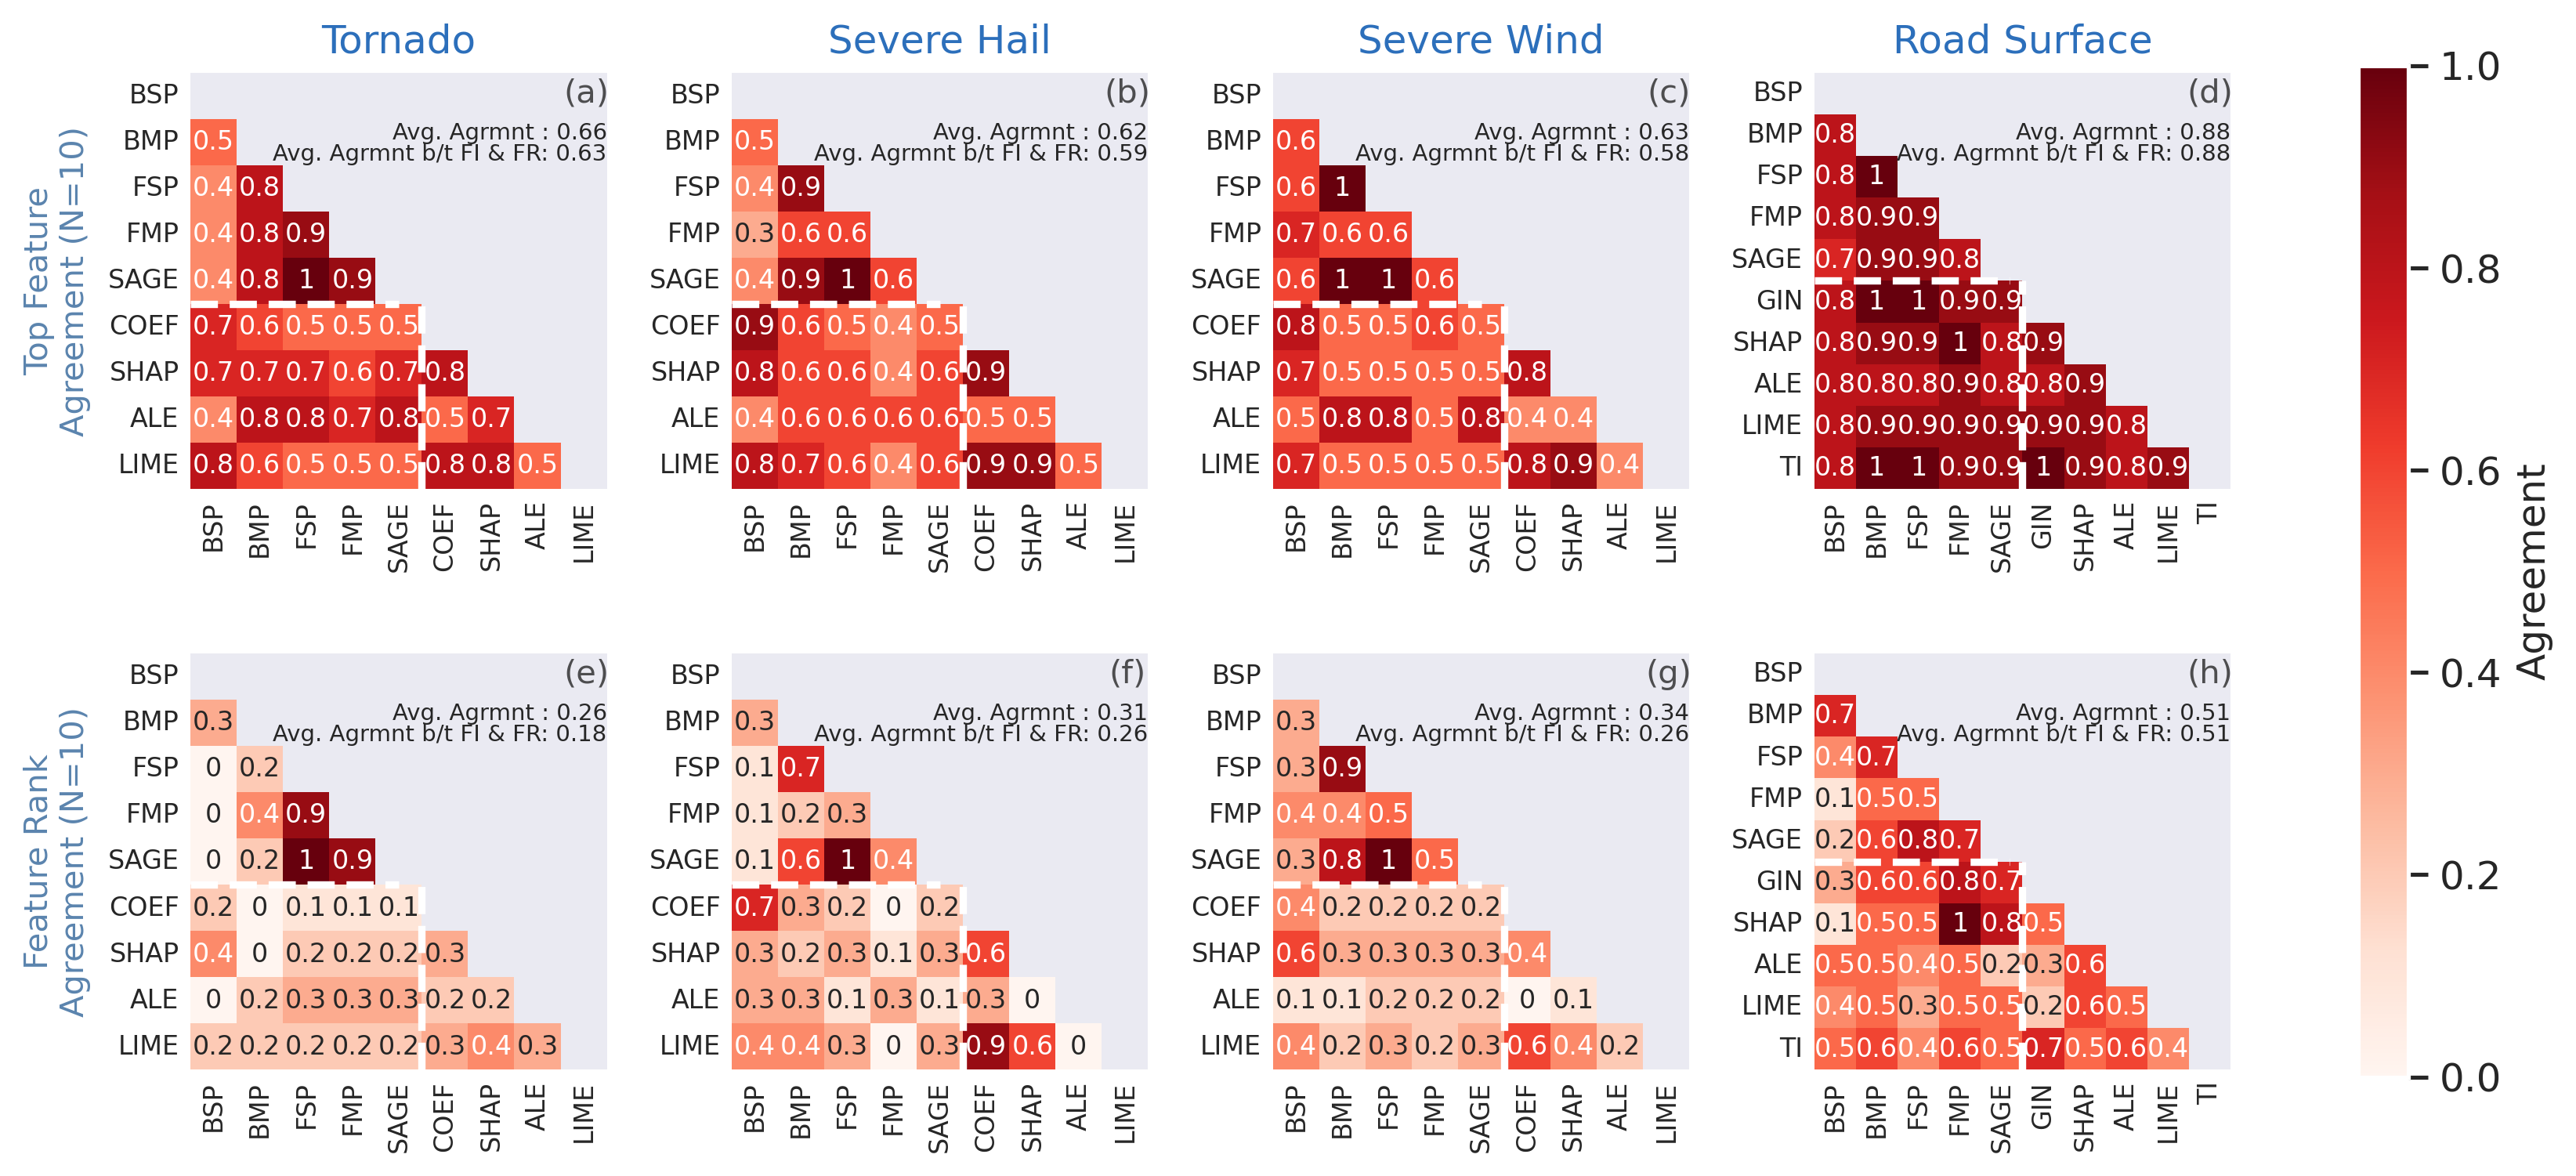

In [8]:
sns.set_theme()
heatmap_multi(results, hazards)